# Image features
<span style="color:green;font-weight:700;font-size:24px"> 
Introduction
</span>

This notebook will be used to talk about some features that may be helpful for various tasks.



In [1]:
from helper_functions import * 

In [2]:
data_ = pd.read_csv('../Data_Entry_fullpath_2017.csv') # read in the file we made earlier that includes full paths 

<span style="color:green;font-weight:700;font-size:24px"> 
Law's Texture features
</span>

Image texture refers to descriptions of small shape patterns in an image. Bumpiness, smoothness, ripple, fibrousness, and porosity are all examples of texture. The Describable textures dataset (DtD) has a number of examples to help think about this. I've put a link to it in the resources section on this cell. 

Law's texture features come from the following feature vectors. \
L5  =  [ +1  +4  6  +4  +1 ]  (Level)\
E5  =  [ -1  -2  0  +2  +1 ]  (Edge)\
S5  =  [ -1   0  2   0  -1 ]  (Spot)\
R5  =  [ +1  -4  6  -4  +1 ]  (Ripple)\
W5  =  [ -1  +2  0  -2  +1 ]  (Wave)

To compute the filters we can take a tensor product between each pair of vectors to get a set of 25 filters. Convoling the features with an image results in energy maps that respond in different amounts to the underlying feature vectors. So L5E5 will generate a map that is sensitive to the pixel intensity level, and to edges. E5W5 would be more sensitive to edge and waviness.


Resources on Image Texture \
[1] https://en.wikipedia.org/wiki/Image_texture \
[2] https://www.robots.ox.ac.uk/~vgg/data/dtd/

In [3]:
# we want this to be a class because we need to get 
# a copy of the filter and hold that in memory before we 
# apply the filters. This is better than having to make the
# filters every time we have a function call. 

class texture_grabber():
    def __init__(self):
        # define an array to hold the 5 vectors of interest
        vecs = np.array(
               [[1, 4, 6, 4, 1],
                [-1, -2, 0, 2, 1],    
                [-1, 0, 2, 0, -1], 
                [1, -4, 6, -4, 1],
                [-1, 2, 0, -2, 1]])
        labs = ['L5', 'E5', 'S5', 'R5', 'W5']
        # vecs = vecs / np.tile(np.expand_dims(np.sum(vecs, axis  = 1), axis=-1), (1, 5))
        # now perform the tensorprodut on each pair of vectors
        # Using a nested for loop for simplicity and readability here 
        mats = []
        lab_mat = []
        for i in range(vecs.shape[0]):
            for j in range(vecs.shape[0]):
                # take tensorproduct
                mats_ = vecs[i,:] * vecs[j,:].T
                # mats_ = norm(mats_)
                mats.append(mats_)
                # append the labels too 
                lab_mat.append(labs[i]+'|'+labs[j])

        mats = np.array(mats)
        print('vector shape', vecs.shape, '\nlaw matrix shape', mats.shape)
        self.mats = 0 + mats # savemats for use in the rest of the class
        self.labs = lab_mat
    
    def call(self, x):
        # list comprehension to convolve each law kernel with the image
        img = np.array([norm(cv2.filter2D(x, ddepth = -1, kernel=m_)) for m_ in self.mats])
        return img

TG = texture_grabber()

vector shape (5, 5) 
law matrix shape (25, 5)


0.0 1.0 0.0 1.0


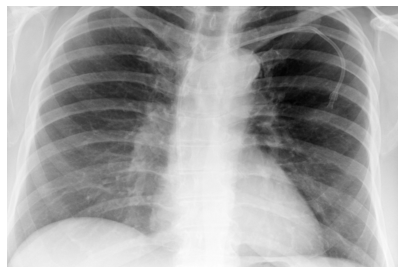

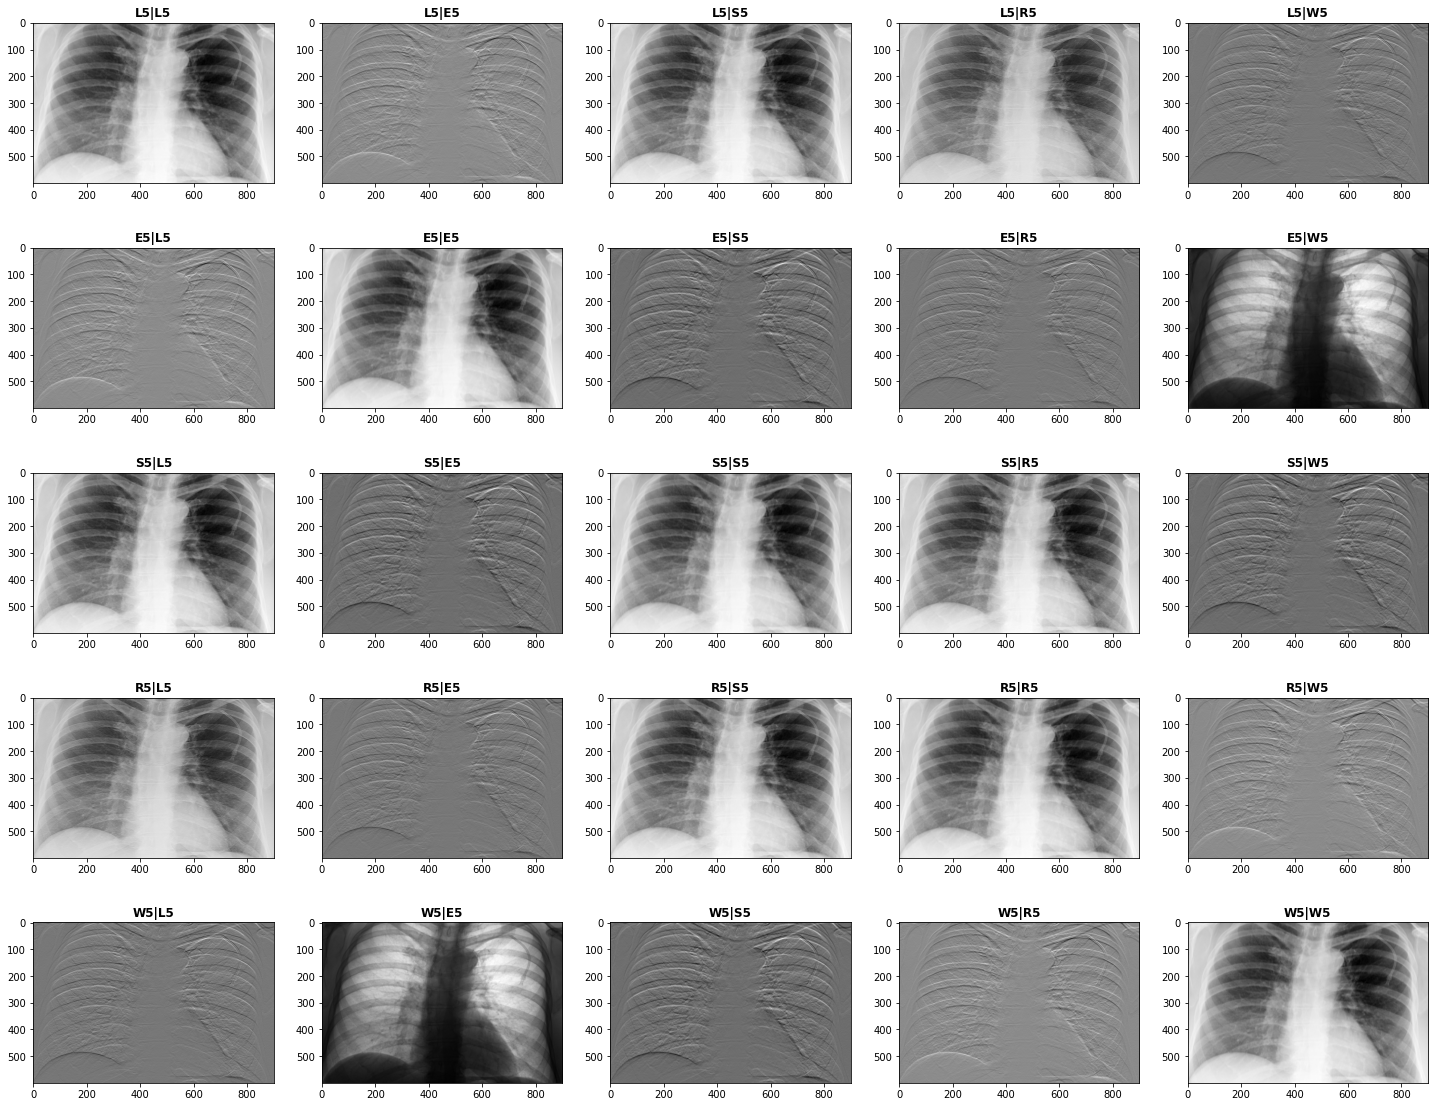

In [4]:
def show_texture_process(TG, data_):
    # conds = get_conditions(data_)
    sub_data = data_[data_['Finding Labels'] == 'No Finding']
    img_ = cv2.imread(sub_data['full_paths'].iloc[1]) # read image as gray scale and normalize
    img_ = img_[200:800, 100:1000]
    img_ = norm(img_)
    quickplot(img_) # show the base image we are working with 
    
    # apply the texture kernels to the input image 
    lt_img_ = TG.call(img_)
    print(np.min(lt_img_), np.max(lt_img_), np.min(img_), np.max(img_))
    # create multifigure object
    mf = multifigure(rows = 5, cols = 5, width =25 , height =20)
    mf.call(norm(lt_img_))
    for j in range(mf.naxes):
        mf.axes[j].set_title(TG.labs[j], weight = 'bold')

show_texture_process(TG, data_)

<span style="color:green;font-weight:700;font-size:24px"> 
Fourier Transforms
</span>

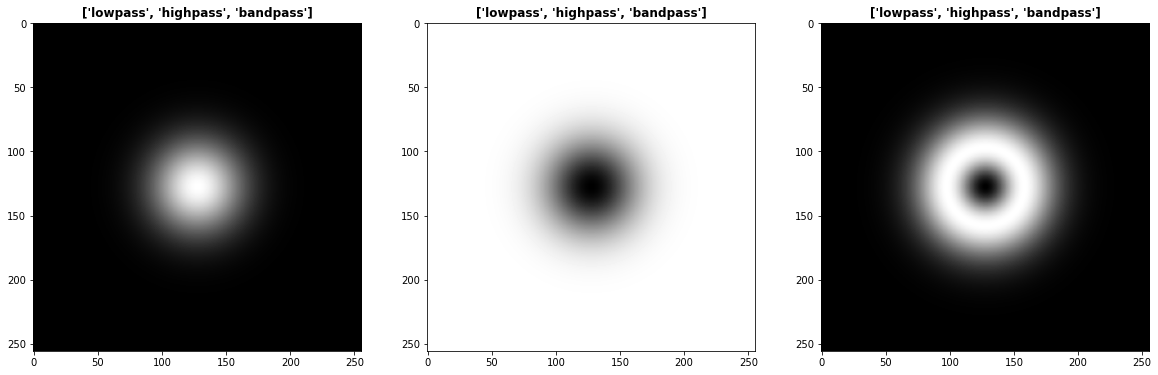

In [5]:
class filter_demo():
    ''' Here is a class to '''
    def __init__(self, samps=256):
        # Create a meshgrid for the frequency domain
        self.rows = 0+samps
        self.cols = 0+samps
        row_indices = np.linspace(-self.rows, self.rows, self.rows)
        col_indices = np.linspace(-self.cols, self.cols, self.cols)        
        
        # the mesh grid will be used for the filters, the hwin will be used for the fft 
        self.row_mesh, self.col_mesh = np.meshgrid(row_indices, col_indices)

    def lowpass(self, cutoff=50):
        # Create a 3D Gaussian filter
        gaussian_filter = norm(np.exp(-(self.row_mesh  ** 2 + self.col_mesh  ** 2) / (2 * (cutoff ** 2))))
        return norm(gaussian_filter)

    def highpass(self, cutoff=50):
        # create highpass filter
        gaussian_filter = 1 - norm(np.exp(-(self.row_mesh  ** 2 + self.col_mesh  ** 2) / (2 * (cutoff ** 2))))
        return norm(gaussian_filter) 

    def bandpass(self,  cutoff = 50):
        win = 5
        lp_cutoff=cutoff+win
        hp_cutoff=cutoff-win

        lp_filter = norm(np.exp(-(self.row_mesh  ** 2 + self.col_mesh  ** 2) / (2 * (lp_cutoff ** 2))))
        hp_filter = 1 - norm(np.exp(-(self.row_mesh  ** 2 + self.col_mesh  ** 2) / (2 * (hp_cutoff ** 2))))
        return norm(lp_filter * hp_filter)
def test0():

    aa = filter_demo()
    lp = aa.lowpass()
    hp = aa.highpass()
    bp = aa.bandpass()
    filts = np.array([lp,hp, bp])
    mf = multifigure(rows = 1, cols = 3, width = 20 , height =20)
    mf.call(filts)

    bpand = ['lowpass', 'highpass', 'bandpass']
    for j in range(mf.naxes):
        mf.axes[j].set_title(bpand, weight = 'bold')
 
test0()

So these images show what our low pass, band pass, and high pass filter look like. The idea is that we can multiply these filter images by the magnitude spectrum of an image of interest. Then when we do the inverse fourier transform we will have an image that only has certain components. For the low pass filter, we keep low frequency components of the image. That is smooth features and things that look like blurring. For the high pass filter we keep high frequency components like edges . The band pass filter will keep fquency components that are in between the two pass bands (the bandwidth of spacial frequencies that we would keep). The radius of each of these circels, is the spatial frequency cut off. 

Normally when we think of frequencies we think of waves that varry in time, like an audio signal. the frequcny unit is 1/s or hertz. So here, we think about spatial waves. Fourrier serries says that with an infinite number of sinusoids we can approximate any signal, so you image is like an infinit number of sine waves in x and y coordintates that are being sumed up. so if the image units are milimeters mm, then the spatial frequency is 1/mm. 

So if we wanted to low pass filter so that we keep object above 5mm, our cut off would be 1/5mm = 0.2 $mm^{-1}$. Now thats important because when we are looking for things like nodules or masses, remember that the size cut off was 3cm. So low pass filtering would let us reject image features below a certain size they are too fine and small to allow through the low frequency pass band. The file Data_Entry_2017.csv has a column called _OriginalImagePixelSpacing[x,y]_. This column gives us the x and y resolution of the original image. so knowing this, we would be able to compute the spatial frequency resolution, and convert a filter radius of say 5 pixels to a filter ratius of x $mm^{-1}$. Also, note that the gaussians do go beyond the cut off - there's a way to rewrite the equation of the gaussian so you have finer control over the full width at half the max intensity (FWHM) [1]. The way we have it defined here is good enough for teaching purposes. 

band pass filtering lets us keep objects between a range of sizes. so in the next cell I'll show you the application of these filters to the chest x-ray. 

[1] https://en.wikipedia.org/wiki/Full_width_at_half_maximum

(1024, 1024)
(3, 1024, 1024)
(1024, 1024)
(3, 1024, 1024)
(1024, 1024)
(3, 1024, 1024)


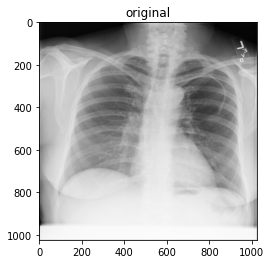

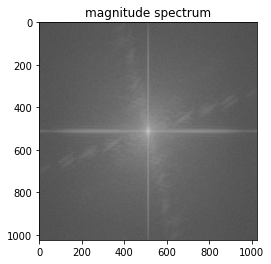

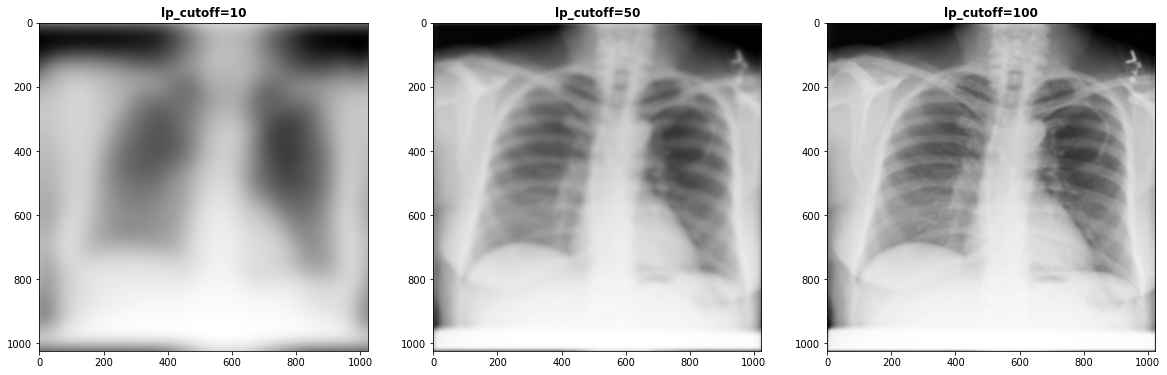

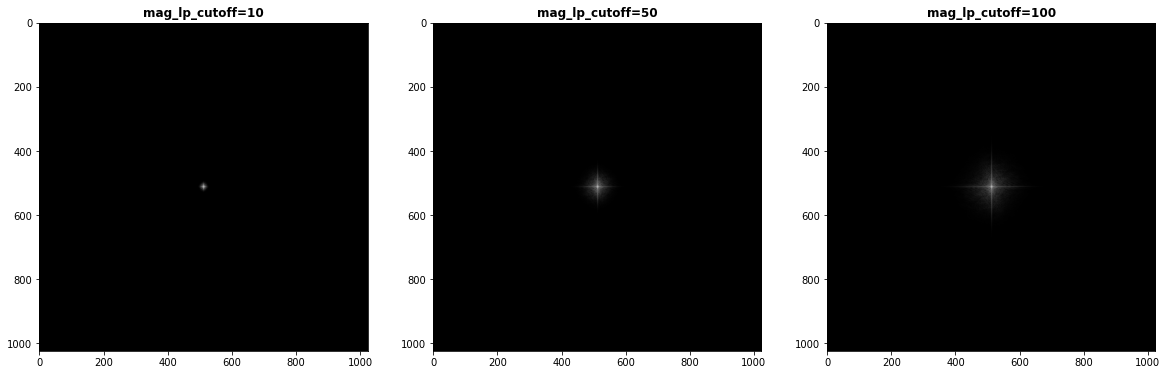

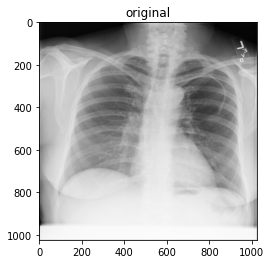

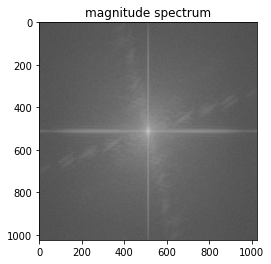

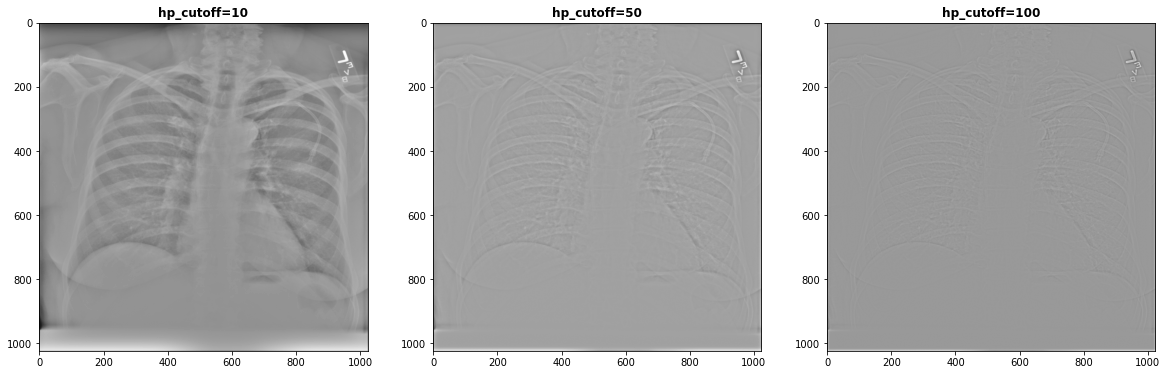

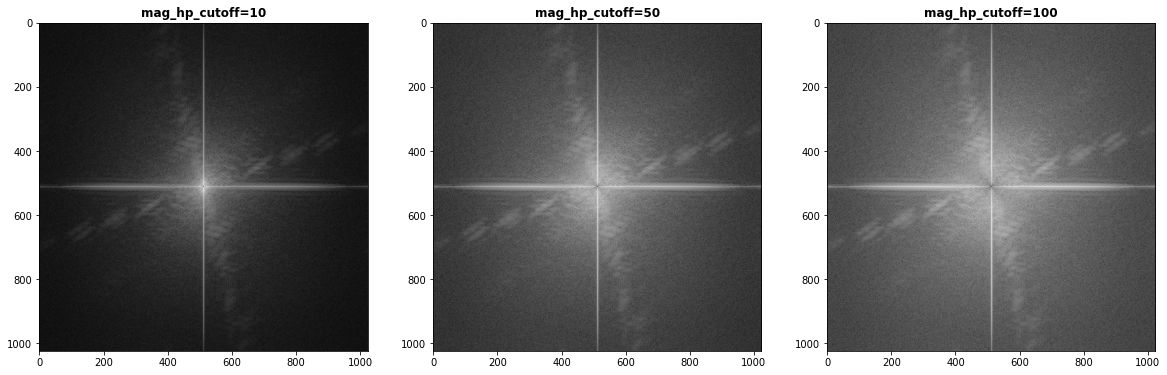

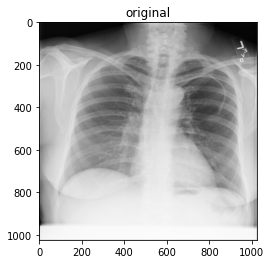

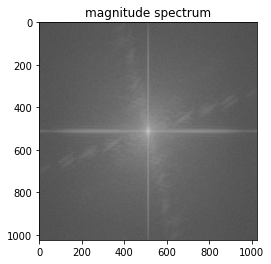

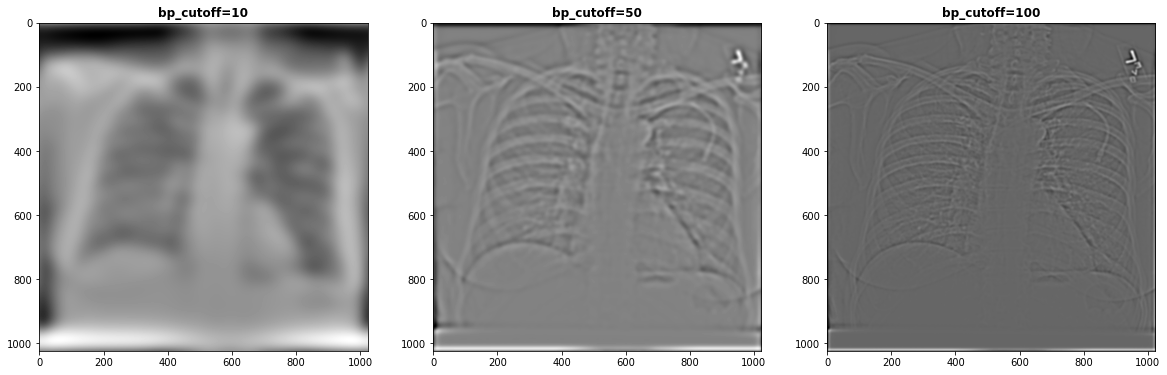

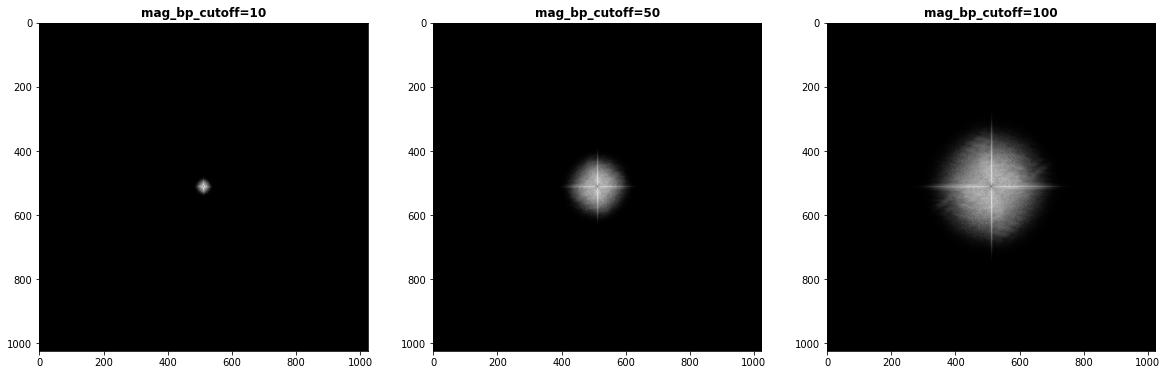

In [6]:
class fft_based_filter():
    ''' Here is a class to '''
    def __init__(self, samps=256):
        # Create a meshgrid for the frequency domain
        self.rows = 0+samps
        self.cols = 0+samps
        row_indices = np.linspace(-self.rows, self.rows, self.rows)
        col_indices = np.linspace(-self.cols, self.cols, self.cols)        
        
        # the mesh grid will be used for the filters, the hwin will be used for the fft 
        self.row_mesh, self.col_mesh = np.meshgrid(row_indices, col_indices)

    def fourier(self, x):
        # Compute the 2D Fourier Transform
        fimg = np.fft.fft2(x)
        fimg = np.fft.fftshift(fimg)
        mag_fimg = np.abs(fimg)
        pha_fimg = np.angle(fimg)
        return fimg, mag_fimg, pha_fimg

    def reconstruct(self, mag, pha):
        # Combine the magnitude and phase spectra -- this follows eulers method
        combined_spectrum = mag * np.exp(1j * pha)

        # Inverse Fourier Transform
        img_reconstructed = np.fft.ifft2(np.fft.ifftshift(combined_spectrum)).real

        return norm(img_reconstructed)

    def lowpass(self, mag_spect, cutoff=50):
        # Create a 3D Gaussian filter
        gaussian_filter = norm(np.exp(-(self.row_mesh  ** 2 + self.col_mesh  ** 2) / (2 * (cutoff ** 2))))
        return norm(gaussian_filter * mag_spect)

    def highpass(self, mag_spect, cutoff=50):
        # create highpass filter
        gaussian_filter = 1 - norm(np.exp(-(self.row_mesh  ** 2 + self.col_mesh  ** 2) / (2 * (cutoff ** 2))))
        return norm(gaussian_filter * mag_spect)

    def bandpass(self, mag_spect, cutoff = 50):
        win = 5
        lp_cutoff=cutoff+win
        hp_cutoff=cutoff-win

        lp_filter = norm(np.exp(-(self.row_mesh  ** 2 + self.col_mesh  ** 2) / (2 * (lp_cutoff ** 2))))
        hp_filter = 1 - norm(np.exp(-(self.row_mesh  ** 2 + self.col_mesh  ** 2) / (2 * (hp_cutoff ** 2))))
        return norm(lp_filter * hp_filter * mag_spect)

def test(pass_ = 'lp'):
    
    sub_data = data_[data_['Finding Labels'] == 'No Finding']
    img_ = cv2.imread(sub_data['full_paths'].iloc[1],0) # read image as gray scale and normalize
    
    img_ = norm(img_)
    # rows, cols, chans = img_.shape
    rows, cols= img_.shape
    print(img_.shape)
    plt.figure()
    plt.imshow(img_, cmap = 'gray')
    plt.title('original')

    # set the filter object
    filter_set = fft_based_filter(rows)
    fimg, mag_fimg, pha_fimg = filter_set.fourier(img_)
    plt.figure()
    plt.imshow(20*np.log10(np.abs(mag_fimg)), cmap='gray')
    plt.title('magnitude spectrum')

    # define a range of cut off frequencies
    cuts = [10, 50, 100]
    lpimgs = []
    fspects = []
    # selector to set low pass, and so on
    select = {'lp':filter_set.lowpass,
              'hp':filter_set.highpass,
              'bp':filter_set.bandpass}
    
    # apply the frequency domain filters
    for cut in cuts:
        lpfimg = select[pass_](mag_fimg, cut) 
        lpimg = filter_set.reconstruct(lpfimg, pha_fimg)
        lpimgs.append(lpimg)
        fspects.append(20*np.log10(np.abs(lpfimg)+0.0001))
    lpimgs = np.array(lpimgs)
    fspects = np.array(fspects)
    
    print(lpimgs.shape)

    mf = multifigure(rows = 1, cols = 3, width = 20 , height =20)
    mf.call(lpimgs)
    
    for j in range(mf.naxes):
        mf.axes[j].set_title(pass_+'_cutoff='+str(cuts[j]), weight = 'bold')
    
    mf2 = multifigure(rows = 1, cols = 3, width = 20 , height =20)
    mf2.call(fspects)
    for j in range(mf.naxes):
        mf2.axes[j].set_title('mag_'+pass_+'_cutoff='+str(cuts[j]), weight = 'bold')

test('lp')
test('hp')
test('bp')

In each set of plots youll see the 3 reconstruciton images and their magnitude spectra shown underneath. This should help get an idea for what the filtering is doing to the frequency components in the images. 


We are able to get different resulting features just by applying out filters in the frequency domain. 
By the way, convolution in the spatial domain, is the same as multiplication in the fequency domain. So we could always multiply matrices in the frequency domain if we wanted to apply a convolutional filter in the spatial domain. 

<span style="color:green;font-weight:700;font-size:24px"> 
Other techniques
</span>

* Edge filters
* wavelet transforms
* gray level co occurence matrices
